In [1]:
import torch
from torch import nn, optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np


In [2]:
# Define the data directories
normal_dir = 'C:\LMS\8\project\Medical student\CQ500_data\Processed_Normal'
hemorrhage_dir = 'C:\LMS\8\project\Medical student\CQ500_data\Processed_Hemorrhage'
# Get the list of all the images
normal_images = [os.path.join(normal_dir, img) for img in os.listdir(normal_dir)]
hemorrhage_images = [os.path.join(hemorrhage_dir, img) for img in os.listdir(hemorrhage_dir)]
# Create labels
normal_labels = [0]*len(normal_images)  # let's assume 0 for normal
hemorrhage_labels = [1]*len(hemorrhage_images)  # and 1 for hemorrhage

# Concatenate data and labels
images = normal_images + hemorrhage_images
labels = normal_labels + hemorrhage_labels


In [3]:
# Split the data into training and validation sets
train_images, val_images, train_labels, val_labels = train_test_split(images, labels, test_size=0.2, random_state=42)

PyTorch uses a Dataset object, which is an abstract class representing a dataset, and a DataLoader, which wraps an iterable around the Dataset. Here's how you can create a custom Dataset for your images:

In [4]:
from torch.utils.data import Dataset
from PIL import Image

class BrainCTDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = Image.open(self.images[idx]).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

from torch.utils.data import DataLoader

# Define transforms for the training and validation sets
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        # transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Create the datasets
train_dataset = BrainCTDataset(train_images, train_labels, transform=data_transforms['train'])
val_dataset = BrainCTDataset(val_images, val_labels, transform=data_transforms['val'])

# Create the dataloaders
dataloaders = {
    'train': DataLoader(train_dataset, batch_size=32,shuffle=True, ),  # num_workers=4 for higher worker we can use os.cpu_count()
    'valid': DataLoader(val_dataset, batch_size=32,shuffle=False,),
}


Training Images:


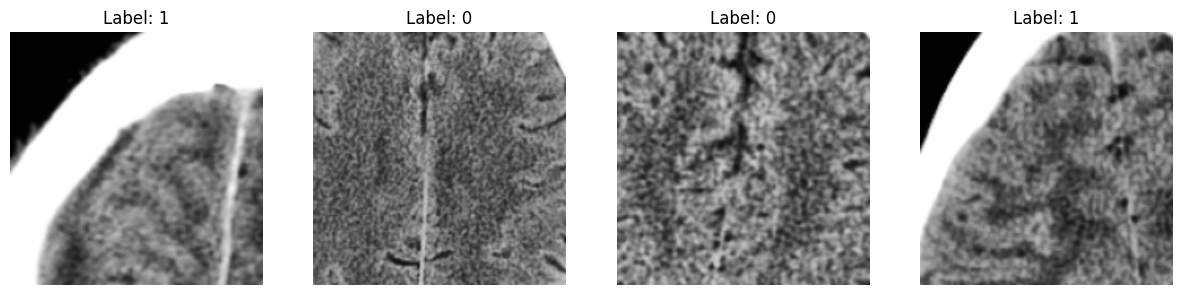

Validation Images:


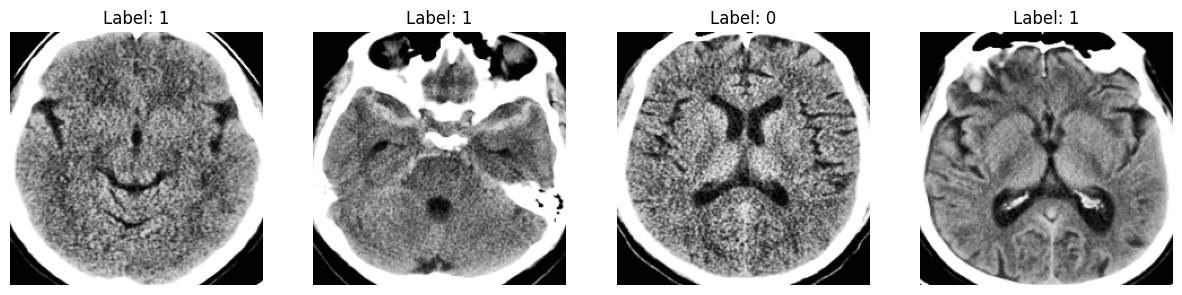

In [5]:
def visualize_random_images(dataloader, num_images=4):
    images, labels = next(iter(dataloader))
    plt.figure(figsize=(15,5))

    for index,image in enumerate(images[:num_images]):
        plt.subplot(1, num_images,index+1)
        # Unnormalize and display the image
        image = image.numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)
        plt.imshow(image)
        plt.title(f"Label: {labels[index].item()}")
        plt.axis("off")
    plt.show()

# Visualize random images from training dataset
print("Training Images:")
visualize_random_images(dataloaders['train'])

# Visualize random images from validation dataset
print("Validation Images:")
visualize_random_images(dataloaders['valid'])


## feature extraction Densnet161


In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model = models.densenet161(pretrained=True)
for param in model.parameters():
    param.requires_grad = False

# Replace the classifier"
model.classifier = nn.Sequential(
    nn.Linear(2208, 512),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(512, 2),
)




model = model.to(device)



cuda:0


C:\Users\moheb\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\moheb\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet161_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet161_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
from torchinfo import summary

summary(model)

Layer (type:depth-idx)                   Param #
DenseNet                                 --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       (14,112)
│    └─BatchNorm2d: 2-2                  (192)
│    └─ReLU: 2-3                         --
│    └─MaxPool2d: 2-4                    --
│    └─_DenseBlock: 2-5                  --
│    │    └─_DenseLayer: 3-1             (101,952)
│    │    └─_DenseLayer: 3-2             (111,264)
│    │    └─_DenseLayer: 3-3             (120,576)
│    │    └─_DenseLayer: 3-4             (129,888)
│    │    └─_DenseLayer: 3-5             (139,200)
│    │    └─_DenseLayer: 3-6             (148,512)
│    └─_Transition: 2-6                  --
│    │    └─BatchNorm2d: 3-7             (768)
│    │    └─ReLU: 3-8                    --
│    │    └─Conv2d: 3-9                  (73,728)
│    │    └─AvgPool2d: 3-10              --
│    └─_DenseBlock: 2-7                  --
│    │    └─_DenseLayer: 3-11            (120,576)
│   

In [8]:
import time
import copy
from tqdm.auto import tqdm

c:\Users\moheb\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    history = {
        'train_loss': [],
        'valid_loss': [],
        'train_acc': [],
        'valid_acc': []
    }

    dataset_sizes = {
        'train': len(train_dataset),
        'valid': len(val_dataset)
    }

    for epoch in tqdm(range(1, num_epochs+1)):
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-' * 10)

        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                        
                _, preds = torch.max(outputs.detach(), 1)

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc.item())

            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        scheduler.step()

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best valid accuracy: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    return model, history


In [10]:
# Define the criterion
criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

# Define the learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# Train the model
model, history = train_model(model, criterion, optimizer, scheduler, num_epochs=50)


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50
----------
train Loss: 0.6529 Acc: 0.6266


  2%|▏         | 1/50 [00:48<39:25, 48.27s/it]

valid Loss: 0.6070 Acc: 0.6793

Epoch 2/50
----------
train Loss: 0.5950 Acc: 0.6894


  4%|▍         | 2/50 [01:29<35:04, 43.85s/it]

valid Loss: 0.5983 Acc: 0.6851

Epoch 3/50
----------
train Loss: 0.5878 Acc: 0.6861


  6%|▌         | 3/50 [02:09<33:13, 42.42s/it]

valid Loss: 0.5961 Acc: 0.6717

Epoch 4/50
----------
train Loss: 0.5806 Acc: 0.6957


  8%|▊         | 4/50 [02:50<31:59, 41.73s/it]

valid Loss: 0.5825 Acc: 0.6885

Epoch 5/50
----------
train Loss: 0.5799 Acc: 0.7010


 10%|█         | 5/50 [03:30<30:56, 41.26s/it]

valid Loss: 0.5784 Acc: 0.6952

Epoch 6/50
----------
train Loss: 0.5543 Acc: 0.7142


 12%|█▏        | 6/50 [04:11<30:11, 41.16s/it]

valid Loss: 0.5917 Acc: 0.6860

Epoch 7/50
----------
train Loss: 0.5558 Acc: 0.7167


 14%|█▍        | 7/50 [04:52<29:21, 40.96s/it]

valid Loss: 0.5831 Acc: 0.6961

Epoch 8/50
----------
train Loss: 0.5565 Acc: 0.7108


 16%|█▌        | 8/50 [05:33<28:39, 40.94s/it]

valid Loss: 0.5854 Acc: 0.6910

Epoch 9/50
----------
train Loss: 0.5535 Acc: 0.7148


 18%|█▊        | 9/50 [06:14<28:07, 41.15s/it]

valid Loss: 0.5830 Acc: 0.6977

Epoch 10/50
----------
train Loss: 0.5558 Acc: 0.7163


 20%|██        | 10/50 [06:56<27:37, 41.44s/it]

valid Loss: 0.5775 Acc: 0.6986

Epoch 11/50
----------
train Loss: 0.5563 Acc: 0.7152


 22%|██▏       | 11/50 [07:38<26:54, 41.41s/it]

valid Loss: 0.5823 Acc: 0.6919

Epoch 12/50
----------
train Loss: 0.5484 Acc: 0.7213


 24%|██▍       | 12/50 [08:19<26:15, 41.47s/it]

valid Loss: 0.5719 Acc: 0.7045

Epoch 13/50
----------
train Loss: 0.5515 Acc: 0.7113


 26%|██▌       | 13/50 [09:00<25:28, 41.32s/it]

valid Loss: 0.5799 Acc: 0.6961

Epoch 14/50
----------
train Loss: 0.5551 Acc: 0.7136


 28%|██▊       | 14/50 [09:42<24:45, 41.28s/it]

valid Loss: 0.5841 Acc: 0.6927

Epoch 15/50
----------
train Loss: 0.5546 Acc: 0.7096


 30%|███       | 15/50 [10:23<24:09, 41.40s/it]

valid Loss: 0.5696 Acc: 0.7053

Epoch 16/50
----------
train Loss: 0.5532 Acc: 0.7176


 32%|███▏      | 16/50 [11:05<23:29, 41.47s/it]

valid Loss: 0.5866 Acc: 0.6885

Epoch 17/50
----------
train Loss: 0.5546 Acc: 0.7182


 34%|███▍      | 17/50 [11:46<22:48, 41.45s/it]

valid Loss: 0.5752 Acc: 0.7086

Epoch 18/50
----------
train Loss: 0.5468 Acc: 0.7203


 36%|███▌      | 18/50 [12:28<22:06, 41.44s/it]

valid Loss: 0.5774 Acc: 0.6994

Epoch 19/50
----------
train Loss: 0.5456 Acc: 0.7182


 38%|███▊      | 19/50 [13:08<21:16, 41.17s/it]

valid Loss: 0.5712 Acc: 0.7036

Epoch 20/50
----------
train Loss: 0.5496 Acc: 0.7180


 40%|████      | 20/50 [13:52<20:56, 41.89s/it]

valid Loss: 0.5853 Acc: 0.6910

Epoch 21/50
----------
train Loss: 0.5462 Acc: 0.7211


 42%|████▏     | 21/50 [14:37<20:39, 42.74s/it]

valid Loss: 0.5878 Acc: 0.6877

Epoch 22/50
----------
train Loss: 0.5512 Acc: 0.7226


 44%|████▍     | 22/50 [15:19<19:58, 42.80s/it]

valid Loss: 0.5831 Acc: 0.6910

Epoch 23/50
----------
train Loss: 0.5519 Acc: 0.7190


 46%|████▌     | 23/50 [16:01<19:08, 42.53s/it]

valid Loss: 0.5763 Acc: 0.7036

Epoch 24/50
----------
train Loss: 0.5450 Acc: 0.7188


 48%|████▊     | 24/50 [16:43<18:20, 42.32s/it]

valid Loss: 0.5738 Acc: 0.7078

Epoch 25/50
----------
train Loss: 0.5473 Acc: 0.7230


 50%|█████     | 25/50 [17:26<17:39, 42.38s/it]

valid Loss: 0.5718 Acc: 0.7070

Epoch 26/50
----------
train Loss: 0.5436 Acc: 0.7211


 52%|█████▏    | 26/50 [18:09<17:05, 42.73s/it]

valid Loss: 0.5894 Acc: 0.6843

Epoch 27/50
----------
train Loss: 0.5573 Acc: 0.7152


 54%|█████▍    | 27/50 [18:53<16:27, 42.94s/it]

valid Loss: 0.5769 Acc: 0.7011

Epoch 28/50
----------
train Loss: 0.5414 Acc: 0.7220


 56%|█████▌    | 28/50 [19:35<15:43, 42.90s/it]

valid Loss: 0.5775 Acc: 0.6994

Epoch 29/50
----------
train Loss: 0.5543 Acc: 0.7138


 58%|█████▊    | 29/50 [20:17<14:50, 42.40s/it]

valid Loss: 0.5814 Acc: 0.6952

Epoch 30/50
----------
train Loss: 0.5542 Acc: 0.7194


 60%|██████    | 30/50 [20:57<13:56, 41.81s/it]

valid Loss: 0.5689 Acc: 0.7078

Epoch 31/50
----------
train Loss: 0.5533 Acc: 0.7184


 62%|██████▏   | 31/50 [21:40<13:19, 42.10s/it]

valid Loss: 0.5694 Acc: 0.7061

Epoch 32/50
----------
train Loss: 0.5498 Acc: 0.7144


 64%|██████▍   | 32/50 [22:23<12:42, 42.34s/it]

valid Loss: 0.5726 Acc: 0.7019

Epoch 33/50
----------
train Loss: 0.5490 Acc: 0.7207


 66%|██████▌   | 33/50 [23:06<12:05, 42.68s/it]

valid Loss: 0.5737 Acc: 0.7003

Epoch 34/50
----------
train Loss: 0.5575 Acc: 0.7163


 68%|██████▊   | 34/50 [23:49<11:22, 42.68s/it]

valid Loss: 0.5839 Acc: 0.6910

Epoch 35/50
----------
train Loss: 0.5557 Acc: 0.7148


 70%|███████   | 35/50 [24:31<10:36, 42.44s/it]

valid Loss: 0.5729 Acc: 0.7070

Epoch 36/50
----------
train Loss: 0.5469 Acc: 0.7245


 72%|███████▏  | 36/50 [25:12<09:50, 42.16s/it]

valid Loss: 0.5852 Acc: 0.6893

Epoch 37/50
----------
train Loss: 0.5563 Acc: 0.7173


 74%|███████▍  | 37/50 [25:53<09:02, 41.71s/it]

valid Loss: 0.5824 Acc: 0.6935

Epoch 38/50
----------
train Loss: 0.5478 Acc: 0.7234


 76%|███████▌  | 38/50 [26:33<08:15, 41.32s/it]

valid Loss: 0.5734 Acc: 0.7019

Epoch 39/50
----------
train Loss: 0.5480 Acc: 0.7201


 78%|███████▊  | 39/50 [27:14<07:30, 41.00s/it]

valid Loss: 0.5804 Acc: 0.6969

Epoch 40/50
----------
train Loss: 0.5392 Acc: 0.7268


 80%|████████  | 40/50 [27:54<06:47, 40.72s/it]

valid Loss: 0.5737 Acc: 0.7036

Epoch 41/50
----------
train Loss: 0.5501 Acc: 0.7197


 82%|████████▏ | 41/50 [28:34<06:04, 40.55s/it]

valid Loss: 0.5787 Acc: 0.7011

Epoch 42/50
----------
train Loss: 0.5448 Acc: 0.7260


 84%|████████▍ | 42/50 [29:14<05:23, 40.50s/it]

valid Loss: 0.5710 Acc: 0.7036

Epoch 43/50
----------
train Loss: 0.5533 Acc: 0.7192


 86%|████████▌ | 43/50 [29:55<04:43, 40.52s/it]

valid Loss: 0.5821 Acc: 0.6927

Epoch 44/50
----------
train Loss: 0.5514 Acc: 0.7264


 88%|████████▊ | 44/50 [30:35<04:03, 40.55s/it]

valid Loss: 0.5764 Acc: 0.6994

Epoch 45/50
----------
train Loss: 0.5497 Acc: 0.7207


 90%|█████████ | 45/50 [31:17<03:24, 40.97s/it]

valid Loss: 0.5941 Acc: 0.6801

Epoch 46/50
----------
train Loss: 0.5508 Acc: 0.7190


 92%|█████████▏| 46/50 [32:03<02:48, 42.23s/it]

valid Loss: 0.5744 Acc: 0.7045

Epoch 47/50
----------
train Loss: 0.5488 Acc: 0.7205


 94%|█████████▍| 47/50 [32:47<02:08, 42.91s/it]

valid Loss: 0.5734 Acc: 0.7045

Epoch 48/50
----------
train Loss: 0.5519 Acc: 0.7094


 96%|█████████▌| 48/50 [33:28<01:24, 42.17s/it]

valid Loss: 0.5769 Acc: 0.7061

Epoch 49/50
----------
train Loss: 0.5478 Acc: 0.7194


 98%|█████████▊| 49/50 [34:09<00:41, 41.96s/it]

valid Loss: 0.5843 Acc: 0.6902

Epoch 50/50
----------
train Loss: 0.5534 Acc: 0.7115


100%|██████████| 50/50 [34:53<00:00, 41.87s/it]

valid Loss: 0.5738 Acc: 0.7095

Training complete in 34m 55s
Best valid accuracy: 0.709488


In [11]:
# Switch to evaluation mode
model.eval()

# Initialize the prediction and label lists
predlist=torch.zeros(0,dtype=torch.long, device='cpu')
lbllist=torch.zeros(0,dtype=torch.long, device='cpu')

with torch.no_grad():
    for i, (inputs, classes) in enumerate(dataloaders['valid']):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        # Append batch prediction results
        predlist=torch.cat([predlist,preds.view(-1).cpu()])
        lbllist=torch.cat([lbllist,classes.view(-1).cpu()])

# Compute the confusion matrix
from sklearn.metrics import confusion_matrix
conf_mat=confusion_matrix(lbllist.numpy(), predlist.numpy())
print('Confusion Matrix')
print('-'*16)
print(conf_mat)

# Compute the classification report
from sklearn.metrics import classification_report
class_report=classification_report(lbllist.numpy(), predlist.numpy())
print('Classification Report')
print('-'*20)
print(class_report)


Confusion Matrix
----------------
[[552 131]
 [215 293]]
Classification Report
--------------------
              precision    recall  f1-score   support

           0       0.72      0.81      0.76       683
           1       0.69      0.58      0.63       508

    accuracy                           0.71      1191
   macro avg       0.71      0.69      0.70      1191
weighted avg       0.71      0.71      0.70      1191



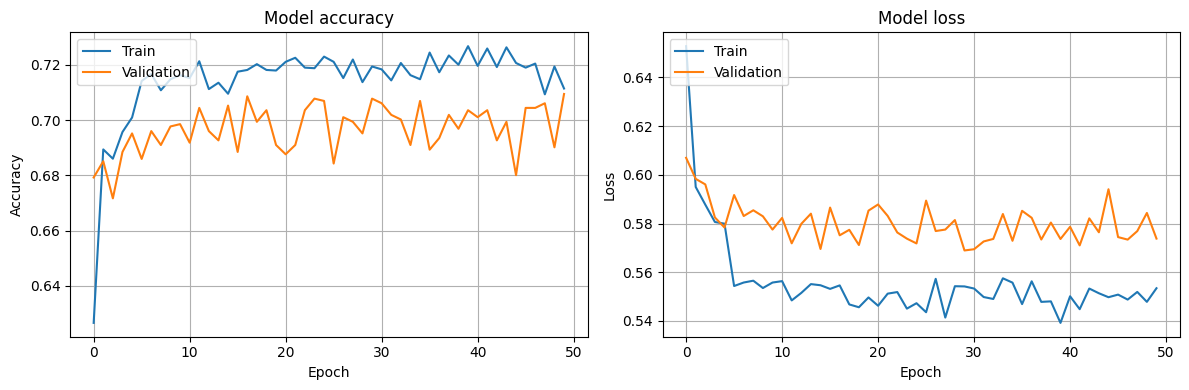

In [12]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    # plot training and validation accuracy values
    ax1.plot(history['train_acc'], label='Train')
    ax1.plot(history['valid_acc'], label='Validation')
    ax1.set_title("Model accuracy")
    ax1.set(xlabel='Epoch', ylabel='Accuracy')
    ax1.legend(loc='upper left')
    ax1.grid(True)

    # plot training and validation loss values
    ax2.plot(history['train_loss'], label='Train')
    ax2.plot(history['valid_loss'], label='Validation')
    ax2.set_title("Model loss")
    ax2.set(xlabel='Epoch', ylabel='Loss')
    ax2.legend(loc='upper left')
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

plot_training_history(history)

In [19]:
model.state_dict()

OrderedDict([('features.conv0.weight',
              tensor([[[[-8.5424e-02, -1.7790e-01, -2.1918e-01,  ..., -2.1247e-01,
                         -1.7470e-01, -1.2502e-01],
                        [-1.1271e-01, -1.8076e-01, -2.1979e-01,  ..., -2.1800e-01,
                         -1.7365e-01, -1.2895e-01],
                        [-6.4315e-02, -1.2065e-01, -1.4375e-01,  ..., -1.3209e-01,
                         -1.2739e-01, -1.0395e-01],
                        ...,
                        [ 6.3051e-02,  7.7100e-02,  9.9101e-02,  ...,  1.1232e-01,
                          1.0000e-01,  8.9417e-02],
                        [ 1.1722e-01,  1.4742e-01,  1.6682e-01,  ...,  1.9763e-01,
                          1.6559e-01,  1.2685e-01],
                        [ 1.2721e-01,  2.0482e-01,  2.4749e-01,  ...,  2.5828e-01,
                          2.0106e-01,  1.6552e-01]],
              
                       [[-1.4774e-01, -2.3783e-01, -2.9080e-01,  ..., -3.0434e-01,
                       